# import

In [5]:
### --- System and Path --- ###
import os
import sys
REPO_PATH = os.path.abspath(os.path.join('..')) # depend on specific directory structure
if REPO_PATH not in sys.path:
    sys.path.append(REPO_PATH)
import warnings
warnings.filterwarnings('ignore')

### --- Data Manipulation --- ###
import pandas as pd
import numpy as np
np.random.seed(42)

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier

In [6]:
# Load: Train Data
df_train = pd.read_csv(REPO_PATH+'/data/table_FUNDRAISE_R2_TRAIN.csv')

# Stage 1: Probability

# Preprocessing

In [7]:
# Preprocessing Utils

def inconsistent(df):
    inconsistent_cols =  ['Recency', 'Frequency', 'Seniority', 'TotalGift', 'MinGift', 'MaxGift']
    # df = df.drop(columns=inconsistent_cols)

    # convert to numeric
    for col in inconsistent_cols:
        df[col] = df[col].str.strip()
        df[col] = pd.to_numeric(df[col], errors='coerce')

    return df

def asdtype(df):
    dtype_dict = {
        'ID': object,
        'Contact': bool,
        'LastName': object,
        'FirstName': object,
        'Woman': bool,
        'Age': int,
        'Salary': int,
        'Education': object,
        'City': object,
        'SeniorList': int,
        'NbActivities': int,
        'Referrals': int,
        'Recency': 'Int64', # nullable integer type
        'Frequency': 'Int64',
        'Seniority': 'Int64',
        'TotalGift': 'Int64',
        'MinGift': 'Int64',
        'MaxGift': 'Int64',
        'GaveLastYear': bool,
        'AmtLastYear': int
    }
    df = df.astype(dtype_dict)

    if 'GaveThisYear' in df.columns:
        df['GaveThisYear'] = df['GaveThisYear'].astype(bool)
    if 'AmtThisYear' in df.columns:
        df['AmtThisYear'] = df['AmtThisYear'].astype(float)

    return df

def NaN_handling(df):
    # # Case-I:
    # # drop selected columns(features) with NaN
    # col = ['Recency', 'Frequency', 'Seniority', 'TotalGift', 'MinGift', 'MaxGift']
    # df = df.drop(columns=col)
    # # drop rows with NaN
    # df = df.dropna(axis=0)

    # Case-II:
    # drop rows only for LastName and FirstName
    df = df.dropna(subset=['LastName', 'FirstName'], axis=0)

    print('#nan:', df.isnull().sum().sum())
    print('remain size:', df.shape)
    return df

def drop_people_name(df):
    # drop columns
    df = df.drop(columns=['LastName', 'FirstName'])
    return df

In [8]:
def preprocessing(df):
    df = inconsistent(df)
    df = asdtype(df)
    df = NaN_handling(df)
    df = drop_people_name(df)
    df.set_index('ID', inplace=True)
    return df

df_train = preprocessing(df_train)

#nan: 3981888
remain size: (999973, 22)


# Feature Engineering

## Binning

numeric -> categorical

(CVXPY) Oct 27 11:36:47 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 27 11:36:47 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.11.4210). Expected < 9.10.0. Please open a feature request on cvxpy to enable support for this version.')
Variable: Recency
Status: OPTIMAL
Splits: [1.5 2.5 3.5]
                 Bin   Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 1.50)  101998   0.102001      77979   24019    0.235485   
1       [1.50, 2.50)   71648   0.071650      56679   14969    0.208924   
2       [2.50, 3.50)   51105   0.051106      40650   10455    0.204579   
3        [3.50, inf)  111574   0.111577      92587   18987    0.170174   
4            Special       0   0.000000          0       0    0.000000   
5            M

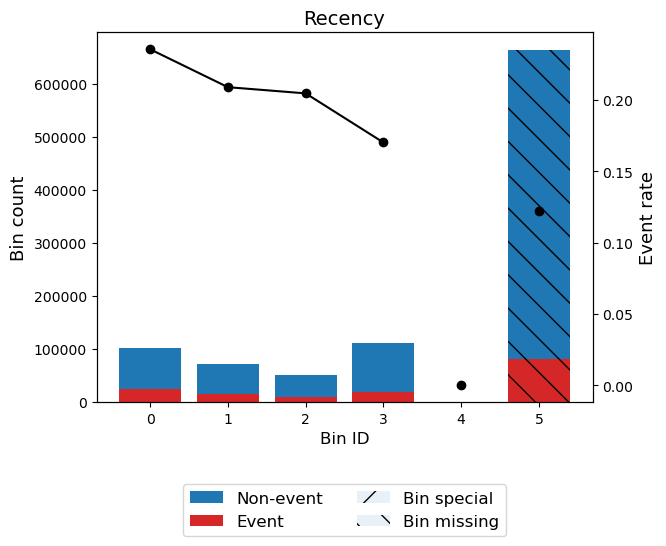

Variable: Frequency
Status: OPTIMAL
Splits: [1.5 2.5]
                 Bin   Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 1.50)  203277   0.203282     169915   33362    0.164121   
1       [1.50, 2.50)   78404   0.078406      60903   17501    0.223216   
2        [2.50, inf)   54644   0.054645      37077   17567    0.321481   
3            Special       0   0.000000          0       0    0.000000   
4            Missing  663648   0.663666     582624   81024    0.122089   
Totals                999973   1.000000     850519  149454    0.149458   

             WoE        IV        JS  
0      -0.110977  0.002602  0.000325  
1      -0.491834  0.022375  0.002769  
2      -0.991883  0.073348  0.008810  
3            0.0  0.000000  0.000000  
4       0.233939  0.033427  0.004169  
Totals            0.131752  0.016073  


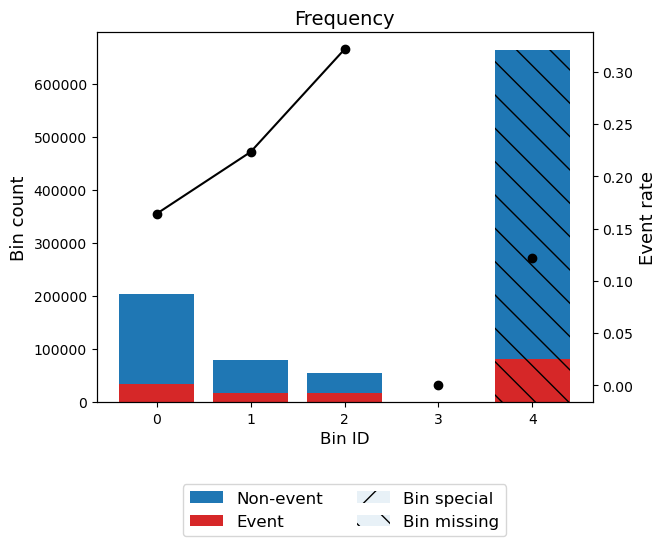

Variable: Seniority
Status: OPTIMAL
Splits: [3.5 6.5]
                 Bin   Count  Count (%)  Non-event   Event  Event rate  \
0       (-inf, 3.50)  140348   0.140352     113976   26372    0.187904   
1       [3.50, 6.50)  113488   0.113491      89999   23489    0.206973   
2        [6.50, inf)   82489   0.082491      63920   18569    0.225109   
3            Special       0   0.000000          0       0    0.000000   
4            Missing  663648   0.663666     582624   81024    0.122089   
Totals                999973   1.000000     850519  149454    0.149458   

             WoE        IV        JS  
0      -0.275173  0.011681  0.001455  
1      -0.395592  0.020313  0.002523  
2      -0.502719  0.024679  0.003053  
3            0.0  0.000000  0.000000  
4       0.233939  0.033427  0.004169  
Totals            0.090100  0.011200  


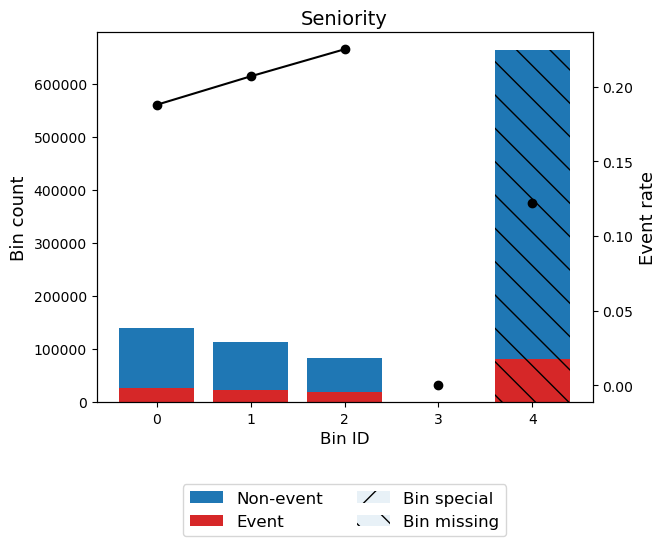

Variable: TotalGift
Status: OPTIMAL
Splits: [ 22.5  32.5  52.5 102.5]
                    Bin   Count  Count (%)  Non-event   Event  Event rate  \
0         (-inf, 22.50)   94311   0.094314      78404   15907    0.168665   
1        [22.50, 32.50)   50726   0.050727      42113    8613    0.169795   
2        [32.50, 52.50)   60081   0.060083      48684   11397    0.189694   
3       [52.50, 102.50)   63376   0.063378      49513   13863    0.218742   
4         [102.50, inf)   67831   0.067833      49181   18650    0.274948   
5               Special       0   0.000000          0       0    0.000000   
6               Missing  663648   0.663666     582624   81024    0.122089   
Totals                   999973   1.000000     850519  149454    0.149458   

             WoE        IV        JS  
0      -0.143742  0.002048  0.000256  
1      -0.151774  0.001232  0.000154  
2      -0.286858  0.005455  0.000680  
3      -0.465846  0.016092  0.001993  
4      -0.769197  0.051508  0.006284  
5 

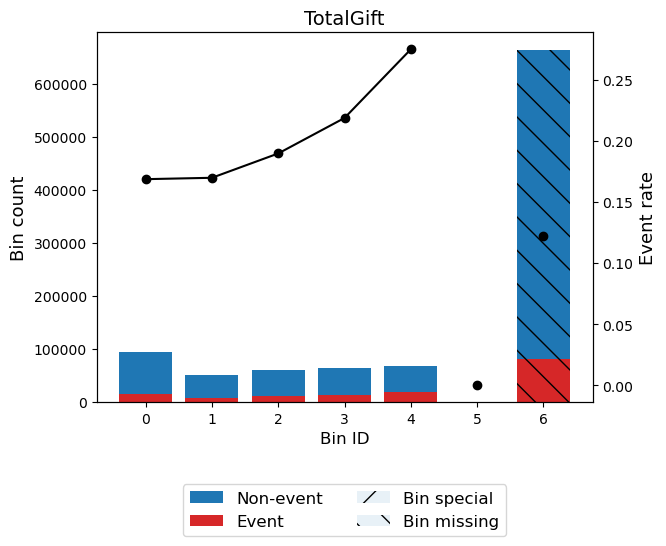

Variable: MinGift
Status: OPTIMAL
Splits: [12.5 22.5 35. ]
                   Bin   Count  Count (%)  Non-event   Event  Event rate  \
0        (-inf, 12.50)   78471   0.078473      60036   18435    0.234928   
1       [12.50, 22.50)  114852   0.114855      90219   24633    0.214476   
2       [22.50, 35.00)   63163   0.063165      51642   11521    0.182401   
3         [35.00, inf)   79839   0.079841      65998   13841    0.173361   
4              Special       0   0.000000          0       0    0.000000   
5              Missing  663648   0.663666     582624   81024    0.122089   
Totals                  999973   1.000000     850519  149454    0.149458   

             WoE        IV        JS  
0      -0.558165  0.029450  0.003634  
1      -0.440705  0.025889  0.003210  
2      -0.238694  0.003907  0.000487  
3      -0.176869  0.002655  0.000331  
4            0.0  0.000000  0.000000  
5       0.233939  0.033427  0.004169  
Totals            0.095328  0.011832  


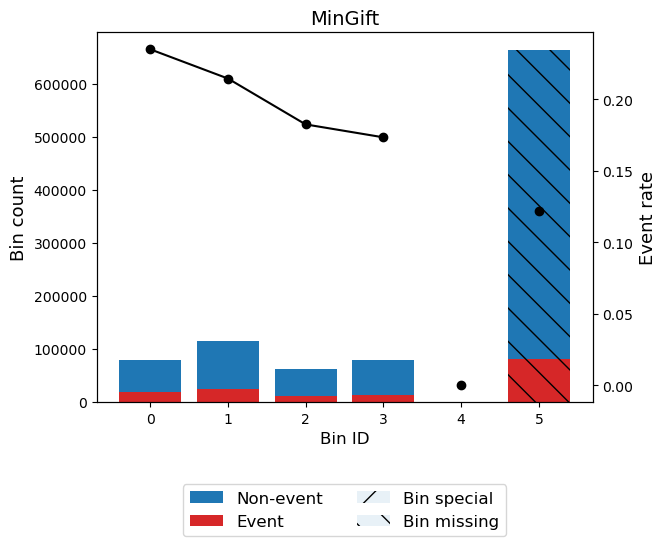

Variable: MaxGift
Status: OPTIMAL
Splits: [22.5 35.  85. ]
                   Bin   Count  Count (%)  Non-event   Event  Event rate  \
0        (-inf, 22.50)  114311   0.114314      93393   20918    0.182992   
1       [22.50, 35.00)   70077   0.070079      56483   13594    0.193987   
2       [35.00, 85.00)   89271   0.089273      70682   18589    0.208231   
3         [85.00, inf)   62666   0.062668      47337   15329    0.244614   
4              Special       0   0.000000          0       0    0.000000   
5              Missing  663648   0.663666     582624   81024    0.122089   
Totals                  999973   1.000000     850519  149454    0.149458   

             WoE        IV        JS  
0      -0.242652  0.007317  0.000912  
1      -0.314547  0.007721  0.000961  
2      -0.403237  0.016644  0.002066  
3      -0.611312  0.028677  0.003530  
4            0.0  0.000000  0.000000  
5       0.233939  0.033427  0.004169  
Totals            0.093786  0.011639  


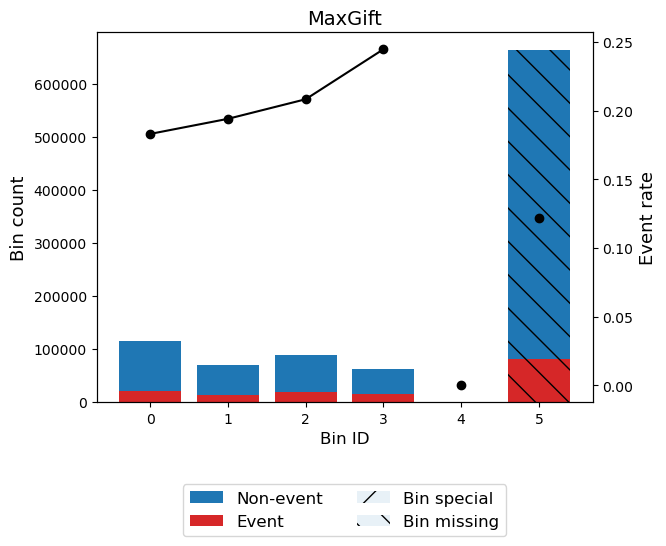

Variable: Age
Status: OPTIMAL
Splits: [23.5 35.5 39.5 44.5 54.5 57.5 62.5 70.5 78.5]
                   Bin   Count  Count (%)  Non-event   Event  Event rate  \
0        (-inf, 23.50)  134420   0.134424     112655   21765    0.161918   
1       [23.50, 35.50)  205130   0.205136     172224   32906    0.160415   
2       [35.50, 39.50)   64326   0.064328      54132   10194    0.158474   
3       [39.50, 44.50)   76447   0.076449      65016   11431    0.149528   
4       [44.50, 54.50)  167145   0.167150     142872   24273    0.145221   
5       [54.50, 57.50)   51824   0.051825      44598    7226    0.139433   
6       [57.50, 62.50)   80460   0.080462      69321   11139    0.138441   
7       [62.50, 70.50)  105813   0.105816      91396   14417    0.136250   
8       [70.50, 78.50)   56374   0.056376      48463    7911    0.140331   
9         [78.50, inf)   58034   0.058036      49842    8192    0.141159   
10             Special       0   0.000000          0       0    0.000000   
11 

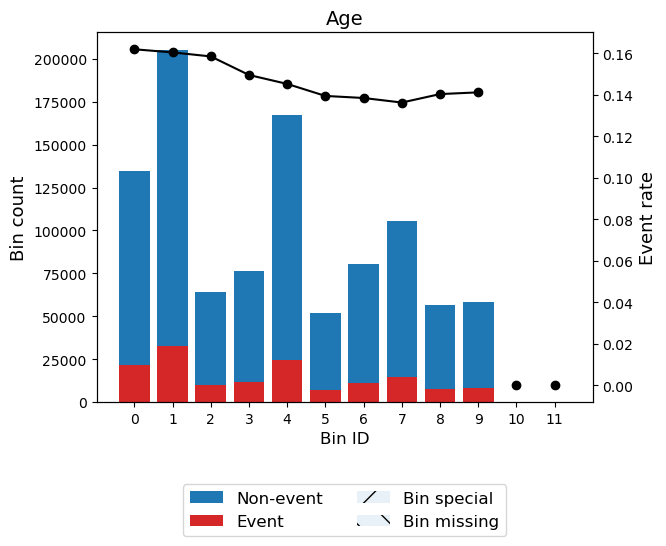

Variable: Salary
Status: OPTIMAL
Splits: [  4350.   9950.  60950.  69250. 108750. 197950.]
                           Bin   Count  Count (%)  Non-event   Event  \
0              (-inf, 4350.00)   50984   0.050985      42946    8038   
1           [4350.00, 9950.00)   53101   0.053102      44775    8326   
2          [9950.00, 60950.00)  526364   0.526378     446463   79901   
3         [60950.00, 69250.00)   50032   0.050033      42455    7577   
4        [69250.00, 108750.00)  113334   0.113337      97048   16286   
5       [108750.00, 197950.00)  148443   0.148447     127242   21201   
6             [197950.00, inf)   57715   0.057717      49590    8125   
7                      Special       0   0.000000          0       0   
8                      Missing       0   0.000000          0       0   
Totals                          999973   1.000000     850519  149454   

        Event rate       WoE        IV        JS  
0         0.157657 -0.063095  0.000207  0.000026  
1         0.15

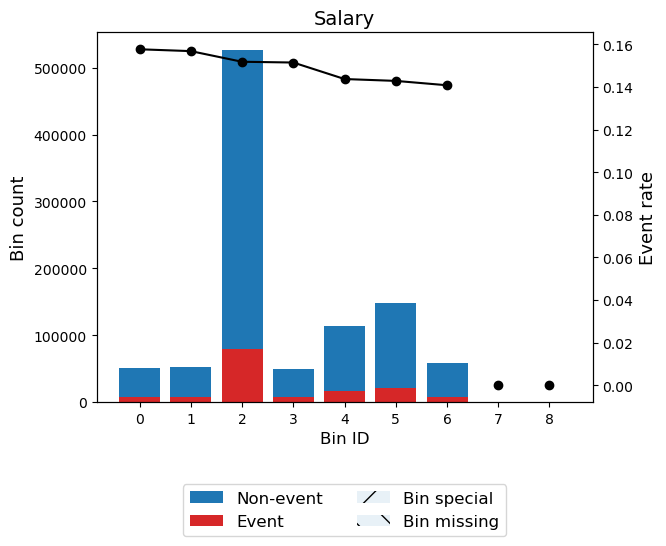

In [9]:
from optbinning import OptimalBinning

def binning_bitrg_train_num(df, cols, target):
    df_tmp = df.copy()
    binning_metadata = {}
    for variable in cols:
        print(f"Variable: {variable}")
        x = df_tmp[variable]
        y = df_tmp[target]

        # Initialize and fit OptimalBinning
        optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
        optb.fit(x, y)

        # Print status and splits for diagnostics
        print(f"Status: {optb.status}")
        print(f"Splits: {optb.splits}")

        # Display binning table and plot event rate
        binning_table = optb.binning_table
        print(binning_table.build())
        binning_table.plot(metric="event_rate")
        binning_metadata[variable] = optb
        # update transform to train data
        x_transform_woe = optb.transform(x, metric="woe")
        df_tmp[variable] = x_transform_woe
        df_tmp.rename(columns={variable: variable+'_WOE'}, inplace=True)

    return df_tmp, binning_metadata

cols = ['Recency', 'Frequency', 'Seniority', 'TotalGift', 'MinGift', 'MaxGift', # included NaN
            'Age', 'Salary'] # numerical
df_train, binning_bitrg_train_num_metadata = binning_bitrg_train_num(df_train.copy(), cols, target='GaveThisYear')


# Training

In [10]:
target = 'GaveThisYear'
X = df_train.drop(columns=[target, 'AmtThisYear'])
y = df_train[target]

# Encoding
def encoding(X):
    cols = X.select_dtypes(include=['object']).columns
    X_enc = pd.get_dummies(X, drop_first=True, columns=cols)
    return X_enc
X = encoding(X)

In [11]:
# Initialize models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    "LogisticRegression": LogisticRegression(class_weight='balanced', random_state=42),
    # "Decision Tree": DecisionTreeClassifier(class_weight='balanced', random_state=42),
    # "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(objective='binary:logistic',eval_metric='logloss',class_weight='balanced',use_label_encoder=False, random_state=42),
    # "LightGBM": LGBMClassifier(class_weight='balanced', verbosity=-1, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42)
}

In [12]:
# Performance
performance_scores = {model_name: {"accuracy": [],
                                   "auc": []} for model_name in models.keys()}

def train_and_evaluate_clf(model, X_train, y_train, X_val, y_val, model_name):
    # Train model
    model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val)

    # Metric
    accuracy = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])  # Probability of the positive class

    performance_scores[model_name]["accuracy"].append(accuracy)
    performance_scores[model_name]["auc"].append(auc)

    print(f"{model_name} Accuracy:", accuracy)
    print(f"{model_name} AUC Score:", auc)
    # print(f"\n{model_name} Classification Report:\n", classification_report(y_val, y_pred))

In [13]:
# Stratified K-Fold Cross Validation
N_FOLDS = 3

n_splits = N_FOLDS
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    print(f"\nFold {fold + 1}")
    print(f"Training samples: {len(train_index)}, Validation samples: {len(val_index)}")
    print(f"Training ratio: {len(y_train) / (len(y_train)+len(y_val)):.2f}, Validation ratio: {len(y_val) / (len(y_train)+len(y_val)):.2f}")
    # Train and evaluate each model
    for model_name, model in models.items():
        train_and_evaluate_clf(model, X_train, y_train, X_val, y_val, model_name)



Fold 1
Training samples: 666648, Validation samples: 333325
Training ratio: 0.67, Validation ratio: 0.33
LogisticRegression Accuracy: 0.7371994299857496
LogisticRegression AUC Score: 0.7254222944983534
XGBoost Accuracy: 0.8609075226880673
XGBoost AUC Score: 0.7365224908584604
CatBoost Accuracy: 0.8609975249381234
CatBoost AUC Score: 0.7358853871572225

Fold 2
Training samples: 666649, Validation samples: 333324
Training ratio: 0.67, Validation ratio: 0.33
LogisticRegression Accuracy: 0.738164668610721
LogisticRegression AUC Score: 0.7243904777333822
XGBoost Accuracy: 0.8604810934706172
XGBoost AUC Score: 0.7344662854024319
CatBoost Accuracy: 0.8604480925465913
CatBoost AUC Score: 0.7339330142353497

Fold 3
Training samples: 666649, Validation samples: 333324
Training ratio: 0.67, Validation ratio: 0.33
LogisticRegression Accuracy: 0.7368746324897097
LogisticRegression AUC Score: 0.7239443201295862
XGBoost Accuracy: 0.8601840851543843
XGBoost AUC Score: 0.734453306758363
CatBoost Accur

In [15]:
# Summary of results
print("\nAverage Performance Across Folds:")
for model_name, scores in performance_scores.items():
    avg_accuracy = np.mean(scores["accuracy"])
    avg_auc = np.mean(scores["auc"])
    print(f"{model_name}: Average Accuracy = {avg_accuracy:.4f}, Average AUC = {avg_auc:.4f}")



Average Performance Across Folds:
LogisticRegression: Average Accuracy = 0.7374, Average AUC = 0.7246
XGBoost: Average Accuracy = 0.8605, Average AUC = 0.7351
CatBoost: Average Accuracy = 0.8606, Average AUC = 0.7347


# OOF Prediction

In [16]:
# Load: Test data
df_test_c = pd.read_csv(REPO_PATH+'/data/table_FUNDRAISE_R2_CONTACT_SCOREDATA.csv')
df_test_nc = pd.read_csv(REPO_PATH+'/data/table_FUNDRAISE_R2_NOCONTACT_SCOREDATA.csv')

In [17]:
def binning_bitrg_test_num(df, binning_metadata=binning_bitrg_train_num_metadata):
    df_tmp = df.copy()
    for variable, optb in binning_metadata.items():
        x = df_tmp[variable]
        x_transform_woe = optb.transform(x, metric="woe")
        # update transform to test data
        df_tmp[variable] = x_transform_woe
        df_tmp.rename(columns={variable: variable+'_WOE'}, inplace=True)

    return df_tmp


In [18]:
# Run through the same pipeline on TrainData.

# Preprocessing
df_test_c = preprocessing(df_test_c)
df_test_nc = preprocessing(df_test_nc)

# Feature Engineering
# - Binning Numerical
df_test_c = binning_bitrg_test_num(df_test_c)
df_test_nc = binning_bitrg_test_num(df_test_nc)

# Encoding
df_test_c = encoding(df_test_c)
df_test_nc = encoding(df_test_nc)

# sort columns to match with TrainDate
train_cols = X.columns
df_test_c = df_test_c.reindex(columns=train_cols)
df_test_nc = df_test_nc.reindex(columns=train_cols)

#nan: 3614820
remain size: (999973, 20)
#nan: 3614820
remain size: (999973, 20)


In [20]:
# Probabilities predictions
model = models['CatBoost']

y_pred_c_P = model.predict_proba(df_test_c)[:, 1]
y_pred_c_P = pd.Series(y_pred_c_P, index=df_test_c.index)

y_pred_nc_P = model.predict_proba(df_test_nc)[:, 1]
y_pred_nc_P = pd.Series(y_pred_nc_P, index=df_test_c.index)

In [21]:
# Avg P(Donate)
y_pred_avg_P = (y_pred_c_P + y_pred_nc_P) / 2
y_pred_avg_P.name = 'pred_prob_GaveThisYear'

# Stage 2: Amount

In [24]:
# Load: Train data
df_train = pd.read_csv(REPO_PATH+'/data/table_FUNDRAISE_R2_TRAIN.csv')

In [25]:
# Preprocessing
df_train = preprocessing(df_train)

# fillna
df_train.fillna(0, inplace=True)

#nan: 3981888
remain size: (999973, 22)


In [26]:
# from optbinning import ContinuousOptimalBinning

# def binning_contrg_train_num(df, cols, target):
#     df_tmp = df.copy()
#     binning_metadata = {}
#     for variable in cols:
#         print(f"Variable: {variable}")
#         x = df_tmp[variable]
#         y = df_tmp[target]

#         # Initialize and fit
#         optb = ContinuousOptimalBinning(name=variable, dtype="numerical")
#         optb.fit(x, y)

#         # Print status and splits for diagnostics
#         print(f"Status: {optb.status}")
#         print(f"Splits: {optb.splits}")

#         # Display binning table and plot event rate
#         binning_table = optb.binning_table
#         print(binning_table.build())
#         binning_table.plot(show_bin_labels=True)
#         binning_metadata[variable] = optb

#         # update transform to train data
#         x_transform_mean = optb.transform(x, metric="mean")
#         df_tmp[variable] = x_transform_mean
#         df_tmp.rename(columns={variable: variable+'_bins'}, inplace=True)

#     return df_tmp, binning_metadata


# cols = ['Recency', 'Frequency', 'Seniority', 'TotalGift', 'MinGift', 'MaxGift', # included NaN
#             'Age', 'Salary'] # numerical
# df_train, binning_contrg_train_num_metadata = binning_contrg_train_num(df_train.copy(), cols, target='AmtThisYear')


In [200]:
# def log_transform(df, cols):
#     for col in cols:
#         df[col] = np.log1p(df[col])
#         df.rename(columns={col: 'log_' + col}, inplace=True)
#     return df


# cols = ['Age', 'Salary', 'Referrals', 'Recency', 'Frequency', 'TotalGift', 'MinGift', 'MaxGift', 'AmtLastYear']

# df_train = log_transform(df_train, cols)

In [190]:
# StandardScaler

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df = df_train
# df['log_Referrals_scaled'] = scaler.fit_transform(df[['log_Referrals']])


# Training

In [27]:
target = 'AmtThisYear'
X = df_train.drop(columns=[target, 'GaveThisYear'])
# merge with avg P(Donate)
X = X.merge(y_pred_avg_P, how='left', left_index=True, right_index=True)

y = df_train[target]
training_feats = X.columns

# Encoding
def encoding(X):
    cols = X.select_dtypes(include=['object']).columns
    X_enc = pd.get_dummies(X, drop_first=True, columns=cols)
    return X_enc
X = encoding(X)

In [28]:
# Initialize models
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

models = {
    "LinearRegression": LinearRegression(),
    "XGBoost": XGBRegressor(objective='reg:squarederror', eval_metric=mean_absolute_error, random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42)
}

In [29]:
# Performance
performance_scores = {model_name: {"MAE": [],
                                   "RMSE": [],
                                   "R2": []} for model_name in models.keys()}

# Training function
def train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name):
    # Train model
    model.fit(X_train, y_train)
    # Predict on validation set
    y_pred = model.predict(X_val)

    # Metric
    mae = mean_absolute_error(y_val, y_pred)
    rmse = root_mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    # store
    performance_scores[model_name]["MAE"].append(mae)
    performance_scores[model_name]["RMSE"].append(rmse)
    performance_scores[model_name]["R2"].append(r2)
    # print
    print(f"{model_name} Mean Absolute Error (MAE):", mae)
    print(f"{model_name} Root Mean Squared Error (RMSE):", rmse)
    print(f"{model_name} R2 Score:", r2)


In [30]:
# Stratified K-Fold Cross Validation
n_splits = N_FOLDS
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(skf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    print(f"\nFold {fold + 1}")
    print(f"Training samples: {len(train_index)}, Validation samples: {len(val_index)}")
    print(f"Training ratio: {len(y_train) / (len(y_train)+len(y_val)):.2f}, Validation ratio: {len(y_val) / (len(y_train)+len(y_val)):.2f}")

    # Train and evaluate each model
    for model_name, model in models.items():
        train_and_evaluate(model, X_train, y_train, X_val, y_val, model_name)



Fold 1
Training samples: 666648, Validation samples: 333325
Training ratio: 0.67, Validation ratio: 0.33
LinearRegression Mean Absolute Error (MAE): 15.221844531514662
LinearRegression Root Mean Squared Error (RMSE): 90.6665541117785
LinearRegression R2 Score: 0.009604748433412857
XGBoost Mean Absolute Error (MAE): 15.330576117487922
XGBoost Root Mean Squared Error (RMSE): 92.21951153671651
XGBoost R2 Score: -0.024613241628506755
CatBoost Mean Absolute Error (MAE): 15.078542781158793
CatBoost Root Mean Squared Error (RMSE): 91.83051680839003
CatBoost R2 Score: -0.015987549887563235

Fold 2
Training samples: 666649, Validation samples: 333324
Training ratio: 0.67, Validation ratio: 0.33
LinearRegression Mean Absolute Error (MAE): 15.22303759889973
LinearRegression Root Mean Squared Error (RMSE): 89.69224925628914
LinearRegression R2 Score: 0.009534685828219702
XGBoost Mean Absolute Error (MAE): 15.416544313778731
XGBoost Root Mean Squared Error (RMSE): 93.05906717077517
XGBoost R2 Scor

In [31]:
# Summary of results
print("\nAverage Performance Across Folds:")
for model_name, scores in performance_scores.items():
    avg_mae = np.mean(scores["MAE"])
    avg_rmse = np.mean(scores["RMSE"])
    avg_r2 = np.mean(scores["R2"])
    print(f"{model_name}: Average MAE = {avg_mae:.4f}, Average RMSE = {avg_rmse:.4f}, Average R² = {avg_r2:.4f}")



Average Performance Across Folds:
LinearRegression: Average MAE = 15.2494, Average RMSE = 90.4816, Average R² = 0.0096
XGBoost: Average MAE = 15.4019, Average RMSE = 93.0099, Average R² = -0.0467
CatBoost: Average MAE = 15.1111, Average RMSE = 91.9132, Average R² = -0.0222


# Voting Ensemble

In [32]:
y_pred_train_A_lin = models["LinearRegression"].predict(X)
y_pred_train_A_xgb = models["XGBoost"].predict(X)
y_pred_train_A_cat = models["CatBoost"].predict(X)

# merge
df_y_pred_train_A = pd.DataFrame(
    {
        "Actual": y,
        "LinearRegression": y_pred_train_A_lin,
        "XGBoost": y_pred_train_A_xgb,
        "CatBoost": y_pred_train_A_cat,
    }
)
df_y_pred_train_A.index = X.index

X_vote = df_y_pred_train_A.drop(columns='Actual')
y_vote = df_y_pred_train_A['Actual']

In [270]:
# from sklearn.linear_model import Lasso, Ridge

# # * config space
# alphas = np.logspace(-5, 5, 100)

# coefs = []
# for alpha in alphas:
#     # choose model
#     model = Lasso(alpha=alpha) # L1
#     # model = Ridge(alpha=alpha)

#     model.fit(X_vote, y_vote)
#     coefs.append(model.coef_)

# # Plot
# plt.figure(figsize=(16, 9))
# for i in range(3):
#     plt.plot(alphas, [coef[i] for coef in coefs], label=f"Feature {i+1}")
# plt.xscale("log")
# plt.xlabel("Alpha")
# plt.ylabel("Coefficient Value")
# plt.title("Regression Coefficients Shrinkage")
# plt.legend()
# plt.grid(True)
# plt.show()

In [33]:
# Voting Ensemble
from sklearn.linear_model import Ridge

weights = Ridge(random_state=42).fit(X_vote, y_vote).coef_
print("Weights:", weights)

Weights: [-0.40640069  1.25841201  0.12350092]


# OOF Prediction

In [34]:
# Load: Test data
df_test_c = pd.read_csv(REPO_PATH+'/data/table_FUNDRAISE_R2_CONTACT_SCOREDATA.csv')
df_test_nc = pd.read_csv(REPO_PATH+'/data/table_FUNDRAISE_R2_NOCONTACT_SCOREDATA.csv')

# Run through the same pipeline on TrainData.

# Preprocessing
df_test_c = preprocessing(df_test_c)
df_test_nc = preprocessing(df_test_nc)

# # fillna
df_test_c.fillna(0, inplace=True)
df_test_nc.fillna(0, inplace=True)

# # Feature Engineering
# # - Binning Numerical
# def binning_contrg_test_num(df, binning_metadata=binning_contrg_train_num_metadata):
#     df_tmp = df.copy()
#     for variable, optb in binning_metadata.items():
#         x = df_tmp[variable]
#         x_transform_mean = optb.transform(x, metric="mean")
#         # update transform to test data
#         df_tmp[variable] = x_transform_mean
#         df_tmp.rename(columns={variable: variable+'_bins'}, inplace=True)

#     return df_tmp
# df_test_c = binning_contrg_test_num(df_test_c)
# df_test_nc = binning_contrg_test_num(df_test_nc)

# # - Log Transform
# cols = ['Age', 'Salary', 'Referrals', 'Recency', 'Frequency', 'TotalGift', 'MinGift', 'MaxGift', 'AmtLastYear']
# df_test_c = log_transform(df_test_c, cols)
# df_test_nc = log_transform(df_test_nc, cols)

# Encoding
df_test_c = encoding(df_test_c)
df_test_nc = encoding(df_test_nc)

# merge with avg P(Donate)
df_test_c = df_test_c.merge(y_pred_avg_P, how='left', left_index=True, right_index=True)
df_test_nc = df_test_nc.merge(y_pred_avg_P, how='left', left_index=True, right_index=True)

# sort columns to match with TrainDate
train_cols = X.columns
df_test_c = df_test_c.reindex(columns=train_cols)
df_test_nc = df_test_nc.reindex(columns=train_cols)


#nan: 3614820
remain size: (999973, 20)
#nan: 3614820
remain size: (999973, 20)


In [35]:
# Amount prediction

model = models['CatBoost']

y_pred_c_A = model.predict(df_test_c)
y_pred_c_A = pd.Series(y_pred_c_A, index=df_test_c.index)

y_pred_nc_A = model.predict(df_test_nc)
y_pred_nc_A = pd.Series(y_pred_nc_A, index=df_test_nc.index)

In [1]:
# Amount prediction ver. Voting Ensemble
# Weights: [-0.44224396  0.49169807  0.93771816]

y_pred_c_A_lin = models["LinearRegression"].predict(df_test_c)
y_pred_c_A_xgb = models["XGBoost"].predict(df_test_c)
y_pred_c_A_cat = models["CatBoost"].predict(df_test_c)
y_pred_c_A = y_pred_c_A_lin*weights[0] + y_pred_c_A_xgb*weights[1] + y_pred_c_A_cat*weights[2]
y_pred_c_A = pd.Series(y_pred_c_A, index=df_test_c.index)

y_pred_nc_A_lin = models["LinearRegression"].predict(df_test_nc)
y_pred_nc_A_xgb = models["XGBoost"].predict(df_test_nc)
y_pred_nc_A_cat = models["CatBoost"].predict(df_test_nc)
y_pred_nc_A = y_pred_nc_A_lin*weights[0] + y_pred_nc_A_xgb*weights[1] + y_pred_nc_A_cat*weights[2]
y_pred_nc_A = pd.Series(y_pred_nc_A, index=df_test_nc.index)

NameError: name 'models' is not defined

# Output(ID) Selection

In [36]:
ExpDonate_c = y_pred_c_P * y_pred_c_A
ExpDonate_nc = y_pred_nc_P * y_pred_nc_A

Uplift = ExpDonate_c - ExpDonate_nc
Uplift.sort_values(ascending=False, inplace=True)

In [37]:
# merge
df = pd.concat([y_pred_c_P, y_pred_nc_P, y_pred_c_A, y_pred_nc_A, ExpDonate_c, ExpDonate_nc, Uplift], axis=1)
df.columns = ['y_pred_c_P', 'y_pred_nc_P', 'y_pred_c_A', 'y_pred_nc_A', 'ExpDonate_c', 'ExpDonate_nc', 'Uplift']
df.index.name = 'ID'

# calculate
def expected_donation(df):
    # normalized probability
    df['y_pred_c_normP'] = df['y_pred_c_P'] / (df['y_pred_c_P'] + df['y_pred_nc_P'])
    df['y_pred_nc_normP'] = df['y_pred_nc_P'] / (df['y_pred_c_P'] + df['y_pred_nc_P'])

    # individual total expected donation
    df['ExpDonate'] = df['y_pred_c_A']*df['y_pred_c_normP'] + df['y_pred_nc_A']*df['y_pred_nc_normP']

    return df

df = expected_donation(df)

In [38]:
def nonneg_rlz_expd(df, threshold=60000):
    rlzexpd = df['ExpDonate'].sort_values(ascending=False)

    rlzexpd[:threshold] = rlzexpd[:threshold] - 5
    rlzexpd[threshold:] = rlzexpd[threshold:] - 25

    rlzexpd = rlzexpd[rlzexpd > 0]

    return rlzexpd

rlzexpd = nonneg_rlz_expd(df)

In [39]:
def save_to_csv(df, REPO_PATH=REPO_PATH):
    selected_id = df.reset_index()['ID']

    now = pd.to_datetime('today').strftime('%Y%m%d_%H%M%S')
    filename = now+'-ResultID.csv'
    # save to csv
    selected_id.to_csv(REPO_PATH + '/results/' + filename, index=False)

save_to_csv(rlzexpd)